## Osceola CFLRP 
Model setup and parameterization of LANDIS-II NECN, and the Dynamic Fuels and Fire System extensions. This analysis framework will drive addressing the Osceola National Forest related component of the funded research 'Outcomes Prioritization on Fuel Treatment Placement in Extreme Fire Weather in 3 CFLRP
Landscapes'. <p>
<b>Authors:</b> Dan J Krofcheck, Matthew D Hurteau, Robert R Scheller, and Eva-Louise Loudermilk.<p>
<b>Research Objectives:</b> The overarching goal of the proposed research in the Osceola is to understand how the increasing prevalence of extreme fire weather events will affect above ground carbon, carbon efflux from wildfire, and wildfire burn severity across the landscape. Further, we aim to understand the potential role of management in mitigating the detriment of severe wildfire across the landscape, by optimizing the way fuels treatments are applied to the forest.<p>
<b>General Approach:</b> We are using a dynamic landscape simulation model (LANDIS-II) coupled with a below ground CENTURY NECN extension to track both above and below ground nutrient cycling, and a process based fuels and fire extension (DFFS) to allow fuel types to change as a function of disturbance, management, and biomass succession. We are using DAYMET to drive the growth and succession in the model, and RAWS station data to govern fire and fuels behavior. The specific challenges here involve paramterizing the landscape, developing an intial communities map for the landscape, and parameterizing the fire and fuels characteristics such that all three components interact in a reasonable manner.

#### Required libraries
and data directories

In [1]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats
import random, ast, csv, math

# ------- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

dataDir = 'Z:/Dan K/Osceola/'
dataDirN = 'Y:/DanK/Osceola/common/'
rasterDir = dataDir + 'Ecoregion Generation/Rasters/'
shapeDir = dataDir + 'Ecoregion Generation/Shapefiles/'

sns.set_style("ticks")
sns.set_context('notebook', font_scale=1.5)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


#### Define some custom functions 
These will soon be wrapped up into a module to clean up the notebooks


In [2]:
def importRaster(rasterPath, **kwargs):
    # Open and read in the raster as an array
    raster_ds = gdal.Open(rasterPath)
    rastermap = raster_ds.ReadAsArray()
    
    # Set the default data type to 'float'
    if 'dtype' not in kwargs:
        dtype = 'float'
    rastermap = rastermap.astype(dtype)
    
    # If specified, set the no data value to NaN
    if 'noData' in kwargs:
        rastermap[rastermap == noData] = np.nan
    return rastermap

def plotRaster(image, ax=None, *args, **kwargs):

    # Grab figure axes if none stated
    if ax == None:
         ax = plt.gca()
                   
    # Normalize color scheme
    if 'norm' not in kwargs:
        vmin = kwargs.pop('vmin', None)
        vmax = kwargs.pop('vmax', None)
        if vmin is None:
            vmin = np.min(image) # or what ever
        if vmax is None:
            vmax = np.max(image)
        norm = matplotlib.colors.Normalize(vmin, vmax)
        kwargs['norm'] = norm

    #ax.figure.canvas.draw() # if you want to force a re-draw
    ax.imshow(image, *args, **kwargs)
    # Setup axes
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
def getShpGeom(shapefile):
    shp = fiona.open(shapefile)
    bds = shp.bounds
    shp.close()
    padLON = ((bds[0] - bds[2]) / 2) * 0.05
    padLAT = ((bds[1] - bds[3]) / 2) * 0.05
    ll = (bds[0] + padLON, bds[1] + padLAT)
    ur = (bds[2] - padLON, bds[3] - padLAT)
    midlat = (bds[1] + bds[3]) / 2
    midlon = (bds[0] + bds[2]) / 2
    coords = list(chain(ll, ur))
    return coords, midlat, midlon

def saveAsGeoTiff(spatialRaster, ndarray, outputFileName, epsg):
    templatedf = gdal.Open(spatialRaster)
    template = templatedf.ReadAsArray()
    driver = gdal.GetDriverByName('GTiff')
    outputRaster = driver.Create(outputFileName,
                                 template.shape[1],
                                 template.shape[0],
                                 1, gdal.GDT_Int32)
    
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    dest_wkt = srs.ExportToWkt()
    
    outputRaster.SetGeoTransform(templatedf.GetGeoTransform())
    outputRaster.GetRasterBand(1).WriteArray(ndarray)
    outputRaster.SetProjection(dest_wkt)

    outputRaster.FlushCache()

#### Define the analysis extent
The Osceola national forest is in north Florida. The extent of the forest that will actually be simulated is shown below with the context map of Florida.

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


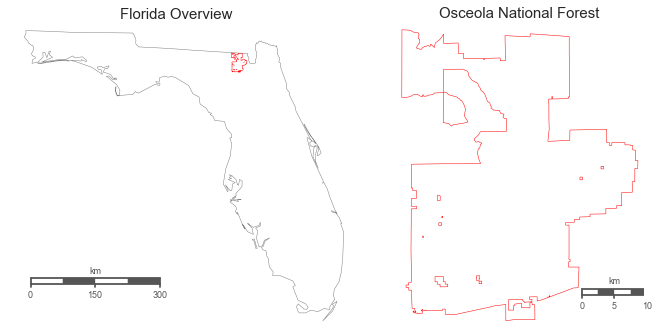

In [3]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
sns.set_style('white')
sns.despine(left = True, bottom = True)

coords, midlat, midlon = getShpGeom(shapeDir + 'Florida_State.shp')

m = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax1);

m.readshapefile(shapeDir + 'Florida_State', 'Florida',
    color='gray', zorder=5);
m.readshapefile(shapeDir + 'OsceolaShape', 'Osceola',
    color='red', zorder=5);


m.drawmapscale(
    coords[0]+2, coords[1]+1,
    coords[0], coords[1],
    300.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

coords, midlat, midlon = getShpGeom(shapeDir + 'OsceolaShape.shp')

m1 = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax2);

m1.readshapefile(shapeDir + 'OsceolaShape', 'Osceola',
    color='red', zorder=5);

m1.drawmapscale(
    coords[0] + 0.35, coords[1] + 0.05,
    coords[0], coords[1],
    10.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

ax1.set_title('Florida Overview', fontsize = 15)
ax2.set_title('Osceola National Forest', fontsize = 15)
plt.tight_layout()
plt.savefig('AreaOverview.tif')

#### Ecoregion generation
First step toward building the Osceola into LANDIS-II is to generate ecoregions -- climatically and edaphically similar areas, wherein soil and climate will provide the same drivers for vegetation growth. The Osceola isn't a huge area (~90k ha) and also is not exceptionally mountainous. This should make creating ecoregions a simple affair. 

The strategy will be to leverage GSSURGO data to describe the major soil types across the landscape, and look for differences in for example water holding capacity. Then we will overlay those differences with crude elevation bands, using elevation as a surrogate for climate -- so long as precipitation and temperature appear to vary across an elevation gradient within the study area.

####GSSURGO data
This always gives me a headache. So here are the steps I used to make sense of the GSSURGO data once its downloaded. I downloaded the data from https://gdg.sc.egov.usda.gov/ on 8-28-2016
1. Load the MapunitRaster into a GIS of your  choice
2. Import two data tables, 'chorizon' and 'component'. I don't understand the naming convention here, chorizon isn't a word, so presumably this stands for c horizon, as the table has a lot of soil horizon data -- clay, sand, silt at various depths etc. However the same logic cannot be applied to 'component', as c omponent doesn't make any sense...
3. Create a spatial join between the MapunitRaster and 'component' using 'MUKEY' from the MapunitRaster (presumably standing for Mapunit Key) and 'Mapunit Key' from 'component'. Why both columns aren't called the same thing, when in fact they represent the same data ...
4. Create a spatial join between MapunitRaster and 'chorizon' using the newly acquired 'Component Key' from MapunitRaster.component. 'chorizon' has the same name for its 'Component Key' column, just to futher add to the confusion via a moment of clarity.
5. Now you have access to the spatial data from 'chorizon' and 'component' on a per MapunitRaster basis.
6. If you want to access the parent group material, useful for splitting up the analysis area into edaphically dissimilar chunks, you need to access the 'copm' table. To make use of it, you need to join it to the MapunitRaster via the 'Component Parent Material Group Key' attribute, which doesn't exist in any of the tables we've joined so far. So, we need an intermediate join that speaks both languages -- namely 'copmgrp'. By joining 'copmgrp' to MapunitRaster via 'Component Key', we can access the parent material columns spatially via our MapunitRaster layer.

The next step isn't entirely intuitive either -- clipping the resulting geodatabase to a smaller vector (e.g., clipping the GSSURGO data for all of FL to just the Osceola extent) requires clipping the 'MUPOLYGON' feature inside the GSSURGO geodatabase. In that manner you end up with a clipped .gdb that retains all associations with the MUKEY and consequently Mapunit Key fields, which you can still relate to soil properties following the steps above.

#### Take a look at edaphic patterns
that might explain some of the variability in soils across the Osceola. Here, sand, silt, and clay content varies spatially, with some start differences across the center of the region. So stark that its probably not real -- I'm half guessing, but i'd wager that this is an artifact of the spatial averaging that goes on within the gSSURGO data. But, its really not that big of a deal, given the tiny range of variability were dealing with. 

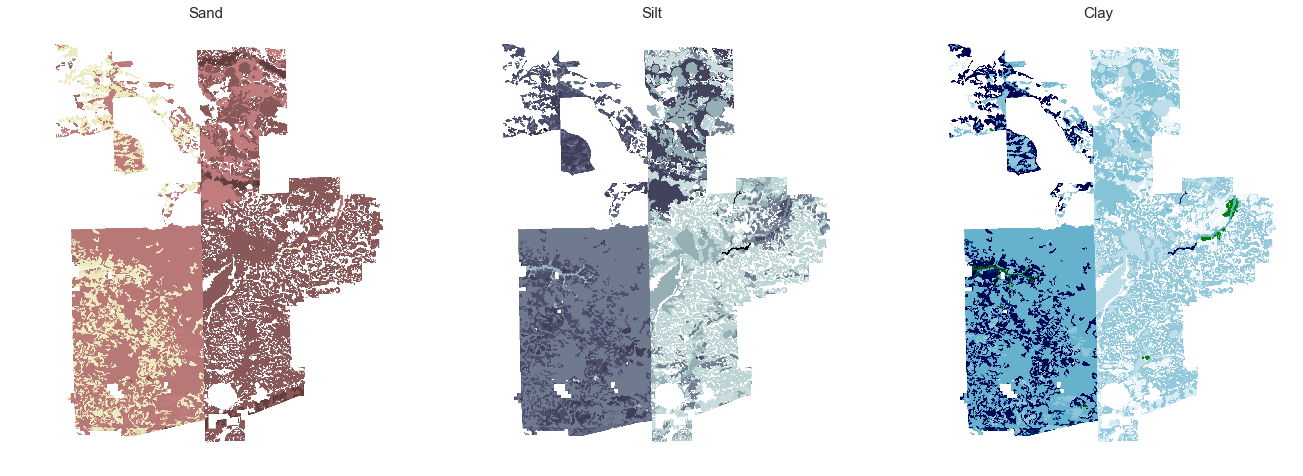

In [4]:
sand = importRaster(rasterDir + 'osceola_sand.tif')
silt = importRaster(rasterDir + 'osceola_silt.tif')
clay = importRaster(rasterDir + 'osceola_clay.tif')

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (24,8))
plotRaster(sand, ax1, cmap = 'pink_r', vmin = 70, vmax = 100)
plotRaster(silt, ax2, cmap = 'bone_r', vmin = 0, vmax = 10)
plotRaster(clay, ax3, cmap = 'ocean_r', vmin = 0, vmax = 25)
plt.subplots_adjust(wspace = 0, hspace = 0.05)
for ax in f.axes:
    ax.set_xticklabels('')
    ax.set_yticklabels('')
ax1.set_title('Sand', fontsize = 15)
ax2.set_title('Silt', fontsize = 15)
ax3.set_title('Clay', fontsize = 15)
plt.savefig('Sand_Silt_Clay.tif')

#### Water holding capacity
GSSURGO data doesn't ship out with a depth normalized water holding capcity product, but you can calculate one using the available water holding capacity columns, and some combination of soil depth columns. I basically normalized AWC by the representative bottom and top soil depths. We see some residual impacts of the spatial abbheration above, albeit a small signal.

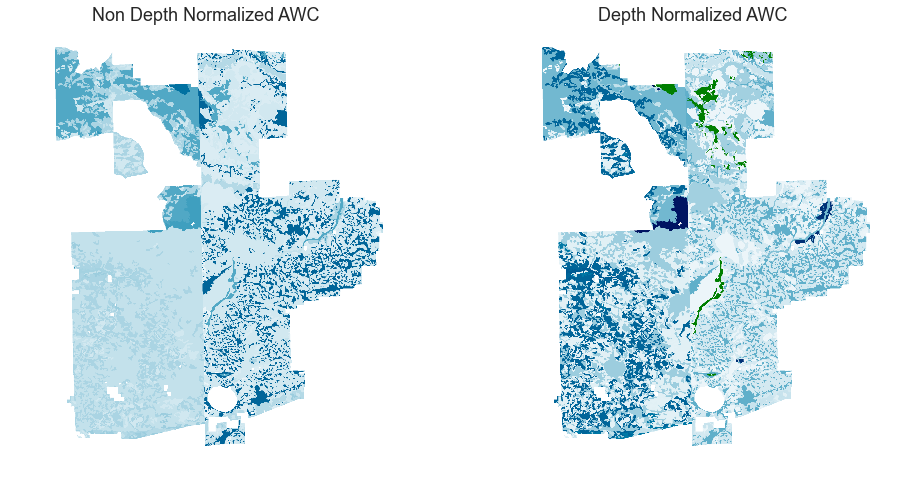

In [5]:
whc = importRaster(rasterDir + 'osceola_whc.tif')
awc = importRaster(rasterDir + 'osceola_awc.tif')

f, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))
plotRaster(awc, ax1, cmap = 'ocean_r', vmin = 0, vmax = 1)
plotRaster(whc, ax2, cmap = 'ocean_r', vmin = 0, vmax = 25)

ax1.set_title('Non Depth Normalized AWC');
ax2.set_title('Depth Normalized AWC');

plt.savefig('Osceola_WaterHolding.tif')

#### Lets look at the elevation across the region
I grabbed a state wide Lidar mosaic from http://www.fgdl.org/ on 8-28-2016. The data came with a metadata vector that indicated the data were acquired in 2013 by the FWC. There are a bunch of holes, some small and some large -- the large holes are mostly meant to be absent, and others are actual holes in the lidar data.  We want to fill the some no data holes, and keep the others. The approach will be to take a focal mean of the raw data, then clip the raw data with a shapefile of the Osceola -- that way the actual holes will be re-stamped out of the filled / smoothed DEM.

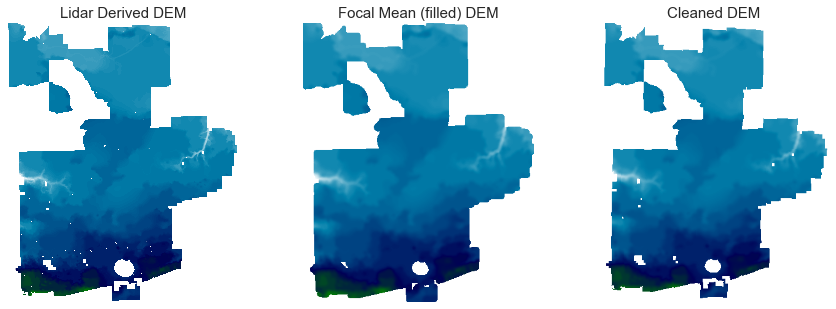

In [6]:
elev = importRaster(rasterDir + 'osceola_lidar.tif')
elev_f = importRaster(rasterDir + 'OsceolaLidar_Filled.tif')
elev_fc = importRaster(rasterDir + 'OsceolaLidar_Filled_Clip_R.tif')

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
plotRaster(elev, ax1, cmap = 'ocean_r', vmin = 90, vmax = 200);
plotRaster(elev_f, ax2, cmap = 'ocean_r', vmin = 90, vmax = 200);
plotRaster(elev_fc, ax3, cmap = 'ocean_r', vmin = 90, vmax = 200);

ax1.set_title('Lidar Derived DEM', fontsize = 15);
ax2.set_title('Focal Mean (filled) DEM', fontsize = 15);
ax3.set_title('Cleaned DEM', fontsize = 15);
plt.savefig('OsceolaElevationHoles.tif')

#### After spatially resampling all datasets and normalizing projections
There is still some inconsistency in the number of pixels per raster layer. This stems from the fact that we were taking raster data from two different sources (gSSURGO and Lidar) and clipping them with the same vector. No big deal, we resampled everything to 100x100 meter grids, then forced the number of rows and columns to equate to the dimensions of the lidar data. This forced the gssurgo products to actually have a non-100 x 100 meter dimension (more like 98.6 x 99.6 or something like that). Thats fine, we're only using it to aggregate edaphic data to the ecoregion scale.

#### Now to create ecoregions
We have information about water holding capacity, which is a function of sand, silt, and clay -- normalized by soil depth. We also have information about elevation, inherent to which is some relative upland vs lowland soil moisture. Really there is an incredible lack of variability in this system topographically, but by crossing 'uplands vs lowlands' with 'low and high WHC', we can capture whatever gradients might exist in reality.

In [7]:
# Create a copy of the elevation raster
elevBins = importRaster(rasterDir + 'OsceolaLidar_Filled_Clip_R.tif')
elevBins[(elev_fc > 0) & (elev_fc < 130)] = 10
elevBins[elev_fc >= 130] = 25

# Create two copies of the WHC raster -- one to reference and one to reclass. 
whc = importRaster(rasterDir + 'OsceolaWHC.tif')
whcBins = importRaster(rasterDir + 'OsceolaWHC.tif')
whcBins[(whc > 0) & (whc < 7)] = 35
whcBins[whc >= 7] = 55

# Create the 'Ecoregion' raster by addition
Ecoregions = elevBins + whcBins

# This addition results in 9 unique values
# (0.,  10.,  25.,  35.,  45.,  55.,  60.,  65.,  80.)
# We only want to keep values that resulted from addition, all else can
# be given a 0 value
Ecoregions[Ecoregions < 26] = 0
Ecoregions[(Ecoregions == 35) | (Ecoregions == 55)] = 0

# Reclassify
Ecoregions[Ecoregions == 45] = 1
Ecoregions[Ecoregions == 60] = 2
Ecoregions[Ecoregions == 65] = 3
Ecoregions[Ecoregions == 80] = 4

#### The result is four ecoregions -- uplands x lowlands, high whc x low whc
Before we can plot it and have it look nice, we need to mask out the 0 values. When we export the raster as a geotiff however, we need to make sure we include them.

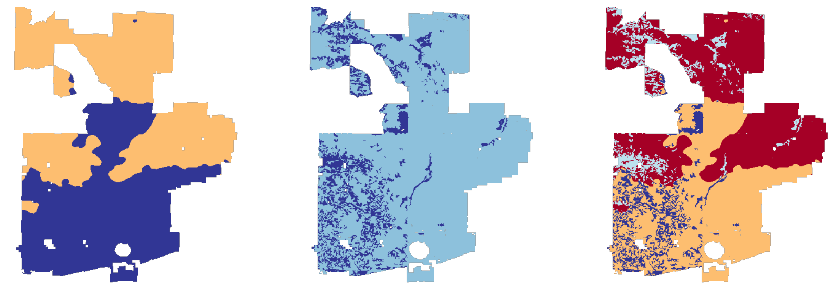

In [8]:
#Mask for plot
Ecoregions[Ecoregions == 0] = np.nan
elevBins[elevBins == 0] = np.nan
whcBins[whcBins == 0] = np.nan

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
plotRaster(elevBins, ax1,cmap = 'RdYlBu', vmin = 5, vmax = 20)
plotRaster(whcBins, ax2,cmap = 'RdYlBu', vmin = 20, vmax = 40)
plotRaster(Ecoregions, ax3, cmap = 'RdYlBu', vmin = 1, vmax = 4)

#### Four ecoregions may even be too many
given the lack of topographic relief in the area, and consequent relative homogeneity of the soils. But, given that the differences we are parsing out are small, the resulting effect on impacting how the model simulates vegetation growth should also be small. 

The next step is to export the raster as a geotiff, then vectorize the layer and appropriate climate data.

In [9]:
saveAsGeoTiff(rasterDir + 'OsceolaLidar_Filled_Clip_R.tif', 
              Ecoregions, rasterDir + 'Osceola_Ecoregions.tif', 26917)

### Following our trip to the Osceola ...
We learned about a couple helpful things. Primarily, this forest is essentially a pine plantation with demographic homogeneity more a function of planting date than anything else. Further, the ecoreigons are essentially 'Swamp' and 'Not Swamp'. Further, we were able to get the fire history for the area as well as a 'burnable' and 'wetlands' layer.

This changes the approach a bit, and basically creates a two ecoregion scenario: swamp and not swamp. Sure makes things simple though, leaving the only major challenge to handle the fuels flammability bifurcation as a function of fire weather.

In [10]:
burnableArea = importRaster('H:\BurnableArea.tif')
wetlandArea = importRaster('H:\WetlandAreas.tif')

burnableArea[burnableArea == 255] = np.nan
wetlandArea[wetlandArea == 255] = np.nan

f, (ax1, ax2) = plt.subplots(1,2, figsize = (14,7))
plotRaster(burnableArea, ax = ax1, cmap = 'RdYlBu')
plotRaster(wetlandArea, ax = ax2, cmap = 'RdYlBu')
ax1.set_title('Burnable Areas')
ax2.set_title('Wetland Areas')

AttributeError: 'NoneType' object has no attribute 'ReadAsArray'

### By combining the burnable and wetland layers...
and clipping by the Osceola boundary, we get the final ecoregions for the simulation. Light green are wetland areas that will draw from wetland FIA data. Dark green are non saturated areas, that will have species and age compositions informed by both FIA and Osceola forest unit stand ages (planting date).

Int values of 1 are burnable area (pine plantation with palmetto understory). Int values of 2 are swamplands (Cyprus, Oak, and Sweetgum overstory with Oaky shrub understory).

#### These regions are also our fire regions
which is super convenient

In [ ]:
osceolaEcoregions = importRaster('H:\OsceolaEcoregions.tif')
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
ecoPal = sns.dark_palette("palegreen", as_cmap=True)

osceolaEcoregions[osceolaEcoregions == 0] = np.nan
f, (ax1) = plt.subplots(1,1, figsize = (7,7))
plotRaster(osceolaEcoregions, ax = ax1, cmap = ecoPal, vmin = 1, vmax = 2)


In [ ]:
saveAsGeoTiff(rasterDir + 'OsceolaLidar_Filled_Clip_R.tif', 
              Ecoregions, rasterDir + 'Osceola_Ecoregions.tif', 26917)

### Ecoregion Sand, Silt, and Clay means by ecoregion
The sand, silt, and clay rasters from above are still useful, and by running zonal stats on the new and improved ecoregion raster above, we can create table means for the parameters that will inform the soil component of the model.

### Parameter scavenger hunt
Complete mess looking for southern pine physiological parameters. I grabbed what I could from the obvious sources, hunted throug the less obvious sources, and then got inventive. We will need to take a look at everything in the model params to make sure it seems reasonable, but for now everything runs and doesnt look broken so its a decent starting spot. JPGs of the tables will be thrown in here for completeness once the paper is out for review.

### Single cell output
Lets take a quick look at some of the single cell runs and do a quick gut check. This was generated using spin up historic climate from CCSM LOCA v2 projections. 

Cohorts of longleaf and slashpine at 40 and 10 years each. 

The palmetto cohorts are set to 20, 40, and 60.

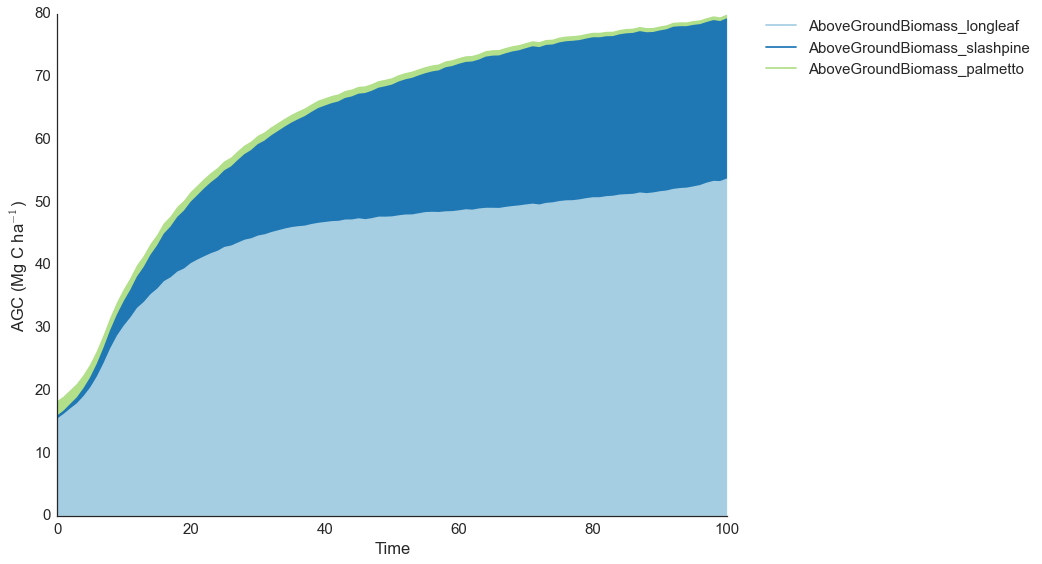

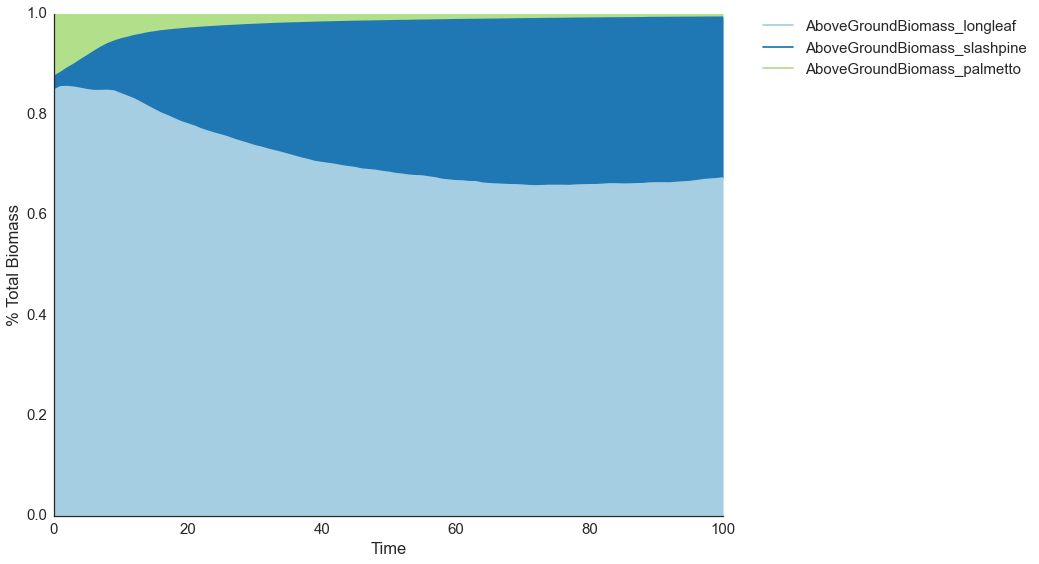

In [11]:
wrkDir = 'C:/Research/Osceola/SingleCell/MixedPine/'

# Read in century output, delete any erronious columns
centuryOutput = pd.read_csv(wrkDir + 'NECN-succession-log.csv')
for col in centuryOutput.columns:
    if 'Unnamed' in col:
        del centuryOutput[col]

# Read in the species biomass log, delete any erronious columns
sppBio = pd.read_csv(wrkDir + 'spp-biomass-log.csv')
for col in sppBio.columns:
    if 'Unnamed' in col:
        del sppBio[col]

# Clean up the species biomass log to contain only columns that are not all NaN
# Remove allcolumns except for the species biomass values (single cell run, no need for
# ecoregion, timestep, etc.)
sppB = sppBio.ix[:,3:]
sppB[sppB == 0] = np.nan
sppB = sppB.dropna(axis='columns', how='all')

# Convert g / m^2 to Mg / ha, then convert AGB to C
sppB = sppB * 0.01 * 0.5

# Species color map -- 9 value quantitative map ColorBrewer
sppColors = ['#a6cee3','#1f78b4','#b2df8a',
             '#33a02c','#fb9a99','#e31a1c',
             '#fdbf6f','#ff7f00','#cab2d6']

# Stacked line plot
f, (ax) = plt.subplots(1,1, figsize=(12, 9))
sppB.plot(ax = ax, kind = 'Area', color = sppColors)
ax.set_ylabel('AGC (Mg C ha$^{-1}$)')
ax.set_xlabel('Time')
maxY = ax.get_ylim()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

# 100% Area plot
f, (ax) = plt.subplots(1,1, figsize=(12, 9))

# Divide each element by the sum of every row
sppRelB = sppB.divide(sppB.sum(axis=1), axis=0)

sppRelB.plot(ax = ax, kind = 'Area', color = sppColors)
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('% Total Biomass')
ax.set_xlabel('Time')
ax.set_ylim([0,1])
sns.despine()

### FIA data wrangling
This always sucks a lot. 

In [12]:
# Load in the FIA data, which is a mess of sheets that need to be related to one another.
FIA_Dir = 'C:/Research/Osceola/FIA/'

# Two sheets used here, the plot data which contains Lat and Lon coordinates (CA_PLOT)
# CA_COND which generally has basic info about the forest type ect of the plots.
allPlotData = pd.read_csv(FIA_Dir + 'FL_Plot.csv')
someForTypes = pd.read_csv(FIA_Dir + 'FL_COND.csv')

# The business end of the plots sheet is CA_TREE.csv, which contains one record for each
# individual measured in each plot. 
allTrees = pd.read_csv(FIA_Dir + 'FL_TREE.csv')

# Apparently the only way to reference a single plot between sheets, is to combine
# the inventory year (INVYR), the state, unit, and county codes (STATECD, UNITCD, COUNTYCD),
# as well as the plot (PLOT). Apparently however, the metadata is incorrect. By adding the CONDID
# column as well, we finally can get unique plot IDs.
allPlotData['PLOT_ID'] = (allPlotData.INVYR.astype(str) + allPlotData.STATECD.astype(str) +
                          allPlotData.UNITCD.astype(str)+ allPlotData.COUNTYCD.astype(str) + 
                          allPlotData.PLOT.astype(str))

someForTypes['PLOT_ID'] = (someForTypes.INVYR.astype(str) + someForTypes.STATECD.astype(str) +
                           someForTypes.UNITCD.astype(str)+ someForTypes.COUNTYCD.astype(str) + 
                           someForTypes.PLOT.astype(str))

allTrees['PLOT_ID'] = (allTrees.INVYR.astype(str) + allTrees.STATECD.astype(str) +
                       allTrees.UNITCD.astype(str)+ allTrees.COUNTYCD.astype(str) + 
                       allTrees.PLOT.astype(str))

# Restrict the plots used by some rough bounding boxes (Lat and Lon)
plotsubset = allPlotData[allPlotData.PLOT_ID.isin(someForTypes.PLOT_ID)]
plotsubsetLL = plotsubset[(plotsubset.LAT > 30.17) & 
                           (plotsubset.LAT < 30.58) & 
                           (plotsubset.LON > -82.61) & 
                           (plotsubset.LON < -82.26)]

# Further restrict FIA plot selection by forest type and Lat / Lon
toUseFIA = someForTypes[someForTypes.PLOT_ID.isin(plotsubsetLL.PLOT_ID)]

# Applying the plot restriction to the tree files
toUseTREES = allTrees[allTrees.PLOT_ID.isin(toUseFIA.PLOT_ID)]

# Find out what forest type codes are extracted, and pull their info just to know what I'm dealing with
print np.unique(toUseFIA.FORTYPCD)

# 141 - Longleaf
# 142 - Slashpine
# 161 - Loblolly
# 164 - Sandpine
# 166 - Pondpine

# 400 - Oak/Pine
# 403 - Longleaf/Oak
# 406 - Loblolly/Hardwood
# 407 - Slashpine/Hardwood

# 520 - Mixed upland hardwoods

# 600 - Oak/Gum/Cypress
# 607 - Baldcypress/water tupelo
# 608 - Sweetbay/Swamp tupelo/red maple

# 706 - Sugarberry/hackberry/elm/green ash
# 999 - nonstocked

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2871: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2871: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[ 141.  142.  161.  164.  166.  400.  403.  406.  407.  520.  600.  607.
  608.  609.  706.  999.   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]


C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2871: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Initial communities creation
This is a royal pain in the ass. No good data, inconsistent data, swamps. The strategy here is to use as much age data as we can from the Osceola GIS shop for better or for worse, then fill in the gaps using the distribution of age data that we have to drive the gap filling. Most of the trees are fairly young, most of them are single age stands, and because we care about differences between scenarios, these assumptions should not derail any of the science. 

For th swamp areas, we will use FIA plots to essentially create the age distributions and fill based on the species listed in the FIA plot TREES database.

#### Starting with the existing age data that we have
I compiled a series of annual prescribed burn layers from '95 to '08, working with inconsistent column headers, projetions, data types... basically everything that could be different between all the geospatial layers was different. I used the Age_Year or AGYR columns whenever I could, and created a simple 'age' column by subtracting AgeYear from 2017. The resulting raster is below.

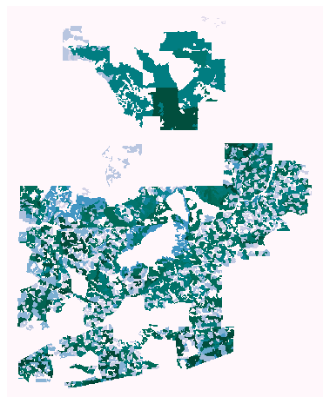

In [13]:
vegAgeData = importRaster('C:/Research/Osceola/SpatialData/ageraster_utm.tif')

vegAgeData[vegAgeData > 200] = 0

f, (ax1) = plt.subplots(1,1, figsize = (7,7))
plotRaster(vegAgeData, ax = ax1, cmap = 'PuBuGn', vmin = 0, vmax = 100)


### If we visualize the data in this raster as a histogram ..
This will be important when it comes to populate the areas of the map for which we do not have explicit age data.

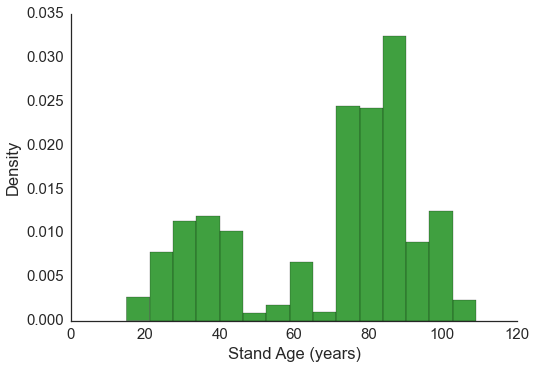

In [14]:
# the histogram of the data
n, bins, patches = plt.hist(vegAgeData[vegAgeData > 10], 15, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('Stand Age (years)')
plt.ylabel('Density')
sns.despine()


### Strategy for assigning ages to raster cells
Figuring out the mean age for each stand isnt too hard. The problem is we need a map for each species type. Lets start by creating a map for the 'Not Swamp' ecoregion. Since these will be primarily single or dual age, and they will be primarily longleaf and slashpine. This is a simple take the age data where we have it, otherwise grab an age at random from the distribution we created above.

In [15]:
# Create some useful rasters

# We need a 'is this cell simulated' raster
# If the cell is simulated, make it a 1
ecoMask = importRaster('H:\OsceolaEcoregions.tif')
ecoMask[ecoMask > 0] = 1

height, width = ecoMask.shape

# We need a blank template raster that we can write over
# No data cells we'll write to 5
initCom = importRaster('H:\OsceolaEcoregions.tif')
initCom[initCom < 5] = 0

for row in range(0,height-1):
    for col in range(0,width-1):
        if osceolaEcoregions[row, col] == 2:
            initCom[row,col] = 0
        if osceolaEcoregions[row, col] == 1:
            if vegAgeData[row,col] != 0:
                initCom[row,col] = vegAgeData[row,col]
            else:
                initCom[row,col] = random.choice(vegAgeData[vegAgeData > 0].ravel())

AttributeError: 'NoneType' object has no attribute 'ReadAsArray'

#### Looks like it sort of worked
The ecoregions map in AX1 shows WHITE where we wanted to fill in age data from AX2. Basically we should have ages from AX2 in AX3 wherever we have WHITE in AX1 ... super clear

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (21,7))
plotRaster(osceolaEcoregions, ax = ax1, vmin = 1, vmax = 2)
plotRaster(vegAgeData, ax = ax2, cmap = 'jet')
plotRaster(initCom, ax = ax3, cmap = 'jet')
ax1.set_title('Ecoregions')
ax2.set_title('Age Data')
ax3.set_title('Pine Age Raster')


### We need to discretize our Pine Age raster
The fastest way to do this is numpy.round()

In [ ]:
roundedPineAge = np.round(initCom, -1)

f, (ax1, ax2) = plt.subplots(1,2, figsize = (14,7))
plotRaster(initCom, ax = ax1, cmap = 'jet')
plotRaster(roundedPineAge, ax = ax2, cmap = 'jet')
ax1.set_title('Raw Age')
ax2.set_title('Rounded Age')

### We have a challenge now, with respect to the odd way LANDIS-II handles the IC
Specifically, we have a set of unique pine max ages, namely those listed  below:

In [ ]:
np.unique(roundedPineAge)

These 10 unique stand ages should represent the cohort composition for three pine species, yet if we were to assign map codes to any of the above grid cells, we need to account for the fact that a mapcode with an 80 yr old cohort with and without a 10 and 30 yr old cohort is unique from mapcodes that lack the 10, the 30, or any other species. How do we handle then creating map codes that link to unique lists of multiple species and cohort ages?

One way is to basically concatenate multiple ages onto the existing age value, using a simple set of logic rules. For instance, a 20 yr cohort has a probability to gaining an additional 20 yr cohort, turning 20 into 2020, or a 50 yr cohort may gain a 20 and a 10 making it 502010. The challenge here then becomes the 100 and 110 yr old cohorts -- how do we distinguish them so that parsing down the line separates out the three character age correctly? One solution is this: for all initial age raster cells containing a 100 yr old cohort, create a flag is.old, where if is.old == True, parse the age code differently.

### After trying that solution out for a bit, it sucked.
I hate to do it because it always feels like a pain in the ass, but I need to create a list of dicts, and use the stand age from the raster above to govern what additional items in the dict get populated. The function buildMapCode below does just that. Basically, we create a database of species age combinations, where the likelihood of additional cohorts is a function of the empirically derived stand age,a nd the dominant species composition across the Osceola. We almost always populate the pine cohorts with one or more cohorts of palmetto as well. This function only creates, essentially a database -- it is not spatially explicit. We generate the spatially explicit product by using this function over a raster of stand ages.

In [ ]:
def buildPineMapCode(standAge):
    # Start by creating a dictionary for the pines for each map code
    # This is empty initially save the longleaf stand age from our age raster
    mapAge = int(standAge)
    leaf = [mapAge]
    slash = [ ]
    lob = [ ]
    palm = [ ]
    # Populate each dictionary item based on the stand age and some probabilities
    if mapAge >= 80:
        
        # Probability that the stand contains equal age slash and or lob
        if np.random.random_sample() > 0.3:
            slash.append(mapAge)
        if np.random.random_sample() > 0.95:
            lob.append(mapAge)

        # Probability that the stand is a 'dual age' stand
        if np.random.random_sample() > 0.7:
            leaf.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.95:
            slash.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.995:
            lob.append(np.random.choice([30,40,50]))

        # Probability that the stand contains 10 yr regen
        if np.random.random_sample() > 0.5:
            leaf.append(10)
        if np.random.random_sample() > 0.5:
            slash.append(10)
        if np.random.random_sample() > 0.9:
            lob.append(10)
           
    elif (mapAge >= 20) & (mapAge < 80):
        # Probability that the stand contains equal age slash and or lob
        if np.random.random_sample() > 0.3:
            slash.append(mapAge)
        if np.random.random_sample() > 0.8:
            lob.append(mapAge)
            
        # Probability that the stand is a 'dual age' stand
        # This is very low, given the age data we have comes from
        # planting ages.
        if np.random.random_sample() > 0.85:
            leaf.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.99:
            slash.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.999:
            lob.append(np.random.choice([30,40,50]))

        # Probability that the stand contains 10 yr regen
        if np.random.random_sample() > 0.5:
            leaf.append(10)      
        if np.random.random_sample() > 0.5:
            slash.append(10)
        if np.random.random_sample() > 0.85:
            lob.append(10)
            
    #if np.random.random_sample() < 0.95:
    palm.append(np.random.choice([[10],[10,20],[10,20,30],[10,20,30,40],[10,20,30,40,50]]))
    mapcode = {'longleaf':list(set(np.round(leaf, -1))), 'slashpine':list(set(np.round(slash, -1))), 
               'loblolly':list(set(np.round(lob, -1))), 'palmetto':list(set(np.round(palm[0], -1)))}

    return mapcode

### Now we step over our age raster, and reference the mapcode database.
This is a bit tricky, basically we take each grid cell for our initial age raster and use it to generate a map code with the above function. However, we need to constantly check if we have an assemblage of species and age cohorts that have already been assigned a mapcode in the past (since we want to use the same map codes for multiple grid cells is possible). This means we have to be checking the new entries in our mapcode database against all existing map codes -- but the list grows with each loop iteration, and the search will take more time. The code below works -- but there's probably a slicker way to handle it.

In [ ]:
# Conduct some benchmarking
import time
tic = time.clock()
osceolaEcoregions = importRaster('H:\OsceolaEcoregions.tif')
ICRaster = importRaster('H:\OsceolaEcoregions.tif')
allIC = [ ]
allUniqueCodes = [ ]
allUniqueCodesMC = [ ]
uniqueIC = 3

for row in range(0,height):
    for col in range(0,width):
        if osceolaEcoregions[row, col] == 1:
            cellIC = buildPineMapCode(roundedPineAge[row,col])
            withCodes = dict(cellIC)

            if uniqueIC == 3:
                ICRaster[row,col] = uniqueIC
                withCodes['MapCode'] = uniqueIC
                allUniqueCodesMC.append(withCodes)
                allUniqueCodes.append(cellIC)
                uniqueIC += 1
                
            if uniqueIC > 3:
                if cellIC not in allUniqueCodes:
                    withCodes['MapCode'] = uniqueIC
                    allUniqueCodes.append(cellIC)
                    allUniqueCodesMC.append(withCodes)
                    ICRaster[row,col] = uniqueIC
                    uniqueIC += 1
                       
                else:
                    # This bit is terribly optimized ... but for now its fine
                    bools = []
                    for code in allUniqueCodes:
                        bools.append(code == cellIC)
                    oldCode = [i for i, x in enumerate(bools) if x]
                    ICRaster[row,col] = allUniqueCodesMC[oldCode[0]]['MapCode']
toc = time.clock()
timetaken = toc - tic
print('iterative mapcode generation and redundancy searching took {0:.1f} seconds'.format(timetaken))
print('and resulted in {0:.1f} unique mapcodes').format(uniqueIC-2)                   


### This ended up working out
And now we have a raster of lookuptable values that references back to a dictionary of species and age cohorts. That means if we need to we could always produce a raster of the IC starting age by species -- this includes mean age, variance of age, etc. Pretty cool. Didn't take too long to sort through the growing list either, but we still have to fill in the gaps for the swamps -- which will be a similar process.

In [ ]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (21,7))
roundedPineAge[roundedPineAge == 0] = np.nan
ICRaster[ICRaster == 0] = np.nan

plotRaster(osceolaEcoregions, ax = ax1, vmin = 1, vmax = 2)
plotRaster(roundedPineAge, ax = ax2, cmap = 'BrBG', vmin = 10, vmax = 110)
plotRaster(ICRaster, ax = ax3, cmap = 'BrBG', vmin = 1, vmax = 4500)

ax1.set_title('Ecoregions')
ax2.set_title('Rounded Age')
ax3.set_title('MapCodes')

### Now we have to do some writing.
The basic format of the initial communities file is a map code, followed by a list of species, and their respective ages. We can iterate over the dinctionary of unique mapcodes, and write down the species followed by their age cohorts. 

In [ ]:
import csv

# Specify the name of the file to create
new_ic_filename = 'C:/Research/Osceola/ic_osceola.txt'
with open(new_ic_filename, "w") as f_new:
    # Write the header of the file, as well as the date the file was created
    f_new.write('LandisData   "Initial Communities" \n')
    f_new.write('>> Generated ' + time.strftime("%m/%d/%Y") + '\n')
    f_new.write('\n')
    
    # Step through the map codes and write the mapcode name comment, followed by the non-zero 
    # species cohorts
    for code in allUniqueCodesMC:
        codestr = str(code['MapCode'])
        codeformat = 'MapCode ' + codestr
        f_new.write('>> MixedPine_' + codestr + '\n')
        f_new.write(codeformat + '\n')
        for key in ['palmetto', 'loblolly', 'slashpine', 'longleaf']:
            if len(code[key]) > 0:
                codeString = key + ' ' + str(code[key]) + '\n'
                f_new.write(codeString.translate(None, '[,]'))
        f_new.write('\n')


### The last step is to populate the swamp data with the remaining FIA plots
that we gathered from the surrounding regions. We have 200+ plots with cyprus data -- we just need to decide to randomly assign a code to each of those plots. The first thing we can do is gather that subset of plots, and look at them. 

In [ ]:
# We have, generally, four swampy forest types to choose from. The species codes listed under each
# forest type compose what will make up the various swamp mapcodes.

# 600 - Oak/Gum/Cypress
# 607 - Baldcypress/water tupelo
# 608 - Sweetbay/Swamp tupelo/red maple
# 706 - Sugarberry/hackberry/elm/green ash

swampTrees = [600, 607, 608, 706]
swampDict = {'baldcypress':221, 'pondcypress':222, 'redmaple':316, 
                    'easternredbud':471, 'lobbay':555, 'sweetbay':653, 
                    'swamptupelo':694, 'laureloak':820}

speciesNames = ['baldcypress','pondcypress','redmaple','lobbay','sweetbay','swamptupelo','laureloak']

### We can leverage the abundance of each species when we create our IC
Quickly looking at the fraction of each species might be useful, but more useful will be looking at the likelihood that the species exists in any given plot. So, turns out only forest type 608 has been inventoried since 2011, if we relax the restraints on when the inventories were collected back to 2001, we capture one plot in forest type 607. The rest we're tossing out since they weren't inventoried since '87. So much for using these plots for biomass validation. In any case, here we list the total plots we plan on using to drive the distribution of swamp species per region.

In [ ]:
# Pull out the plots that have been sampled recently, and are of the correct forest type
recentPlots1 = toUseFIA[(toUseFIA.FORTYPCD == swampTrees[1]) & (toUseFIA.INVYR > 2000)].PLOT_ID
recentPlots2 = toUseFIA[(toUseFIA.FORTYPCD == swampTrees[2]) & (toUseFIA.INVYR > 2010)].PLOT_ID
allPlots = recentPlots1.append(recentPlots2)

# Grab the trees from those plots
# Count the abundance of each species
allTrees = toUseTREES[toUseTREES.PLOT_ID.isin(allPlots)].SPCD
unique, counts = np.unique(allTrees, return_counts=True)
spcCounts = np.asarray((unique, counts)).T

# Keep only the species we care about -- this is important here because the
# FIA plots are larger than many of the swampy areas, so there are lot of pines
# in the plots. I removed these, and species that were incredibly rare, for the sake
# of not increasing the complexity of the model parameterization.
uniqueCodes  = [ ]
uniqueCounts = [ ]
for code in unique:
    if code in swampDict.values():
        uniqueCodes.append(code)
        uniqueCounts.append(counts[np.where(unique==code)][0])

# Wrap the finished data up and create a quick visualization
swampAbundance = pd.DataFrame(dict(SpcCode = uniqueCodes, 
                           SpcCounts = uniqueCounts, 
                           SpcNames = speciesNames))
swampAbundance['SpcP'] = swampAbundance.SpcCounts / swampAbundance.SpcCounts.sum()

f, ax = plt.subplots(1,1, figsize = (8.09,5))

sns.barplot(swampAbundance['SpcNames'], swampAbundance['SpcP'], palette="Set3", ax = ax)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)
ax.set_xlabel('Species')
ax.set_ylabel('Abundance Probability')
sns.set_style('ticks')
sns.despine()

### We dont't have any age data for the swamps ...
but we do have a fire history. Chances are we can leverage that fire history to define another probabilistic framework for selecting stand ages for various cohorts.

###Data driven fire history description
Using a similar approach as in the Dink, we'll plot up the recent fire scars (back to 1998 in this case, its not exactly CalFire) and create a distribution of their size and frequency in an effort to generate the initial params for the DFFS. 

In [ ]:
f, ax = plt.subplots(1,1, figsize = (10,5))
sns.set_style('white')
sns.despine(left = True, bottom = True)

coords, midlat, midlon = getShpGeom('H:\OSCF_FH.shp')

m = Basemap(llcrnrlon=coords[0]-0.05,llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax);

m.readshapefile(shapeDir + 'OsceolaShape', 'Osceola',
    color='black', linewidth = 0.7, zorder=0);

m.readshapefile('H:\OSCF_FH', 'firehist',
    color='gray', zorder=5);

m.drawmapscale(
    coords[0] + 0.35, coords[1] + 0.05,
    coords[0], coords[1],
    10.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

# set up a map dataframe
fireslist = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.firehist]})
for shape in enumerate(df_map['poly']):
    keys, values = m.firehist_info[shape[0]].keys(),m.firehist_info[shape[0]].values()
    fireslist.append(values[26])
df_map['FireRegion'] = fireslist
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

fireslist = map(int, fireslist)
p = PatchCollection(df_map.patches,cmap=plt.get_cmap('RdYlBu_r'))
p.set_array(np.array(fireslist))
p.set_clim([np.ma.min(fireslist),np.ma.max(fireslist)])
ax.add_collection(p)


cbaxes = f.add_axes([0.75, 0.2, 0.015, 0.65]) 
cbar = plt.colorbar(p, cax = cbaxes, ticks = [1998,2015])
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Fire Year', fontsize = 15)
plt.savefig('FireHistory_Osceola.tif', dpi = 300)

#### Quickly generate the lognormal distribution derived from the data above
While we're at it might as well grab the fire size and number of fires per year data for the DFFS parameterization

In [ ]:
metadata = pd.read_csv('H:\OSCF_FH_metadata.txt')
# Data driven approach:
metadata['HECTARES'] = metadata.GIS_AC * 0.404686
firesizeMu = np.log(metadata.HECTARES).mean()
firesizeSd = np.log(metadata.HECTARES).std()
# Modeled approach:
# Limit fires to those > 1 ha
metadata.HECTARES[metadata.HECTARES < 1] = np.nan
firesize = np.log(metadata.HECTARES).dropna()
rvs = firesize # Generate some random variates as data

shape, loc, scale = stats.lognorm.fit(rvs, floc=0) # Fit a curve to the variates
mu = np.log(scale) # Mean of log(X)
sigma = shape # Standard deviation of log(X)
M = np.exp(mu) # Geometric mean == median
s = np.exp(sigma) # Geometric standard deviation

# Plot figure of results
f, ax = plt.subplots(1,1, figsize = (10,5))
n, bins, patches = ax.hist(rvs, bins=25, normed=True) # Plot histogram

x = np.linspace(rvs.min(), rvs.max(), num=400)
g = sns.distplot(rvs, kde=False, ax = ax, 
                 color = 'gray', norm_hist = True);
plt.plot(x, stats.lognorm.pdf(x, shape, 
            loc=0, scale=scale), 'r', linewidth=3) # Plot fitted curve
ax.set_xlabel('Log of Fire Size (ha)', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
sns.despine()
ax.patch.set_facecolor('none')
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.4)

plt.savefig('FireHistory_Osceola_RVS.tif', dpi = 300)
print M, s

In [ ]:
metadata.FIRE_YEAR.count() / (metadata.FIRE_YEAR.max() - metadata.FIRE_YEAR.min())

### Return to GIS for more raster generation
The fire history polygons overlap -- and what we are most interested in is the most recent year an area burned (for the sake of setting up the IC at least). Sounds like we should dissolve the polygon and do some sort of vector to raster conversion. However, in the model (and reality it seems) when a swamp burns, it all goes up, For this reason, there is't much variability within a swamp in terms of age composition. That means it would be ideal if we could treat every swamp unit as its own 'region' from which we draw a more tightly constrained set of mapcodes.

My approach here is to handle the regionalization of the swamps, the rasterization of the fire history polygons, and move forward with those data to drive the species and age draws similar to how we handled the pines.

#### First the regionalization
Handled this in QGIS, using a circular neighborhood clumping algorithm from GRASS GIS. I operated over the ecoregion raster, so that all contiguous areas (both pine and swamp) received a unique linearly increasing cell value. The fact that we operated over the pine regions as well doesn't really matter, since we will be using the ecoregion layer as an initial mask when we iterate over the region to start laying out mapcodes.

In [ ]:
regionalized = importRaster('C:/Research/Osceola/SpatialData/' + 'osceola_regionalized.tif')
regionalized[regionalized == 0] = np.nan
f, (ax1, ax2) = plt.subplots(1,2, figsize = (14,7))
roundedPineAge[roundedPineAge == 0] = np.nan
ICRaster[ICRaster == 0] = np.nan

plotRaster(osceolaEcoregions, ax = ax1, vmin = 1, vmax = 2)
plotRaster(regionalized, ax = ax2, cmap = 'BrBG', vmin = 1, vmax = 3280)

ax1.set_title('Ecoregions')
ax2.set_title('Regionalized')


### Dissolving, rasterizing, generally fixing the fire history vector data
The fire history layer is a dumpster fire. Aside from the metadata being incorrect, the projection mislabled, and the attribute columns cryptic, the topology on this layer is terrible. I ended up first dissolving on fire year, taking the most recent year in the case of attribute overlap. This handled some of the topology issues, but any sort of clip on the vector data was still failing due to the leaky vectors. I iterated over v.clean() in QGIS GRASS 7 to first break, then remove small areas (RMSA) at 0.10 and 0.20 tolerances until I stopped seeing changes to the vector (3-4 passes). At that point, I clipped the dissolved/cleaned vector to the Osceola boundary and rasterized.

In [ ]:
fireYear = importRaster('C:/Research/Osceola/SpatialData/' + 'fire_year.tif')
fireYear[fireYear == -9999] = np.nan
f, (ax1, ax2) = plt.subplots(1,2, figsize = (14,7))
roundedPineAge[roundedPineAge == 0] = np.nan
ICRaster[ICRaster == 0] = np.nan

plotRaster(osceolaEcoregions, ax = ax1, vmin = 1, vmax = 2)
plotRaster(fireYear, ax = ax2, cmap = 'coolwarm', vmin = 1998, vmax = 2015)

ax1.set_title('Ecoregions')
ax2.set_title('Fire Year')


### The strategy for building the swamp component to the IC
will be to iterate over the regionalized raster. Because we are stepping through the raster cell by cell, we may enter the same region more than once. So, we need to track regions, as well as mapcodes -- that way we can make sure we are creating a unique set of mapcodes, and applying the apropriate age distributions on a per region basis. 


### One last layer of complexity
that I think I need imposed on the initial communities map codes -- swamp edges. Walking around in the swamps, I remember the distinct look the edges had -- seemingly dominated more by shrubs and mixed hardwoods rather than the large cypress that I associated with the interior. We need a simple function to check if the current cell we are operating over is an 'edge' cell. Using the regionalized map that we generated previously, this is pretty easy to do. We can have the check for edge cells return a boolean, ultimately that will adjust the probability of species distributions for that map code.

In [ ]:
def isBorderCell( raster, row, col ):
    result = []
    if raster[row,col] != np.nan:
        for x,y in [(row+i,col+j) for i in (-1,0,1) for j in (-1,0,1) if i != 0 or j != 0]:
            if  raster[x,y] != raster[row,col]:
                return True
            else:
                return False
    else:
        return False
            
def roundup(x):
    return int(math.ceil(x / 10.0)) * 10

In [ ]:
def buildSwampMapCode(ROI, fireYear, edge):
    # Start by creating a dictionary for the swampers for each map code
    # This is empty initially save the ROI and latest fire year from our two input rasters
    if np.isnan(fireYear):
        fireAge = np.random.choice(np.arange(10,200,30))
    else:
        fireAge = int(2017-fireYear)
    region        = ROI
    baldcypress   = [ ]
    pondcypress   = [ ]
    redmaple      = [ ]
    lobbay        = [ ]
    sweetbay      = [ ]
    swamptupelo   = [ ]
    laureloak     = [ ]
    
    
    
    # Populate each dictionary item based on the stand age and some probabilities
    if fireAge >= 80:
        if edge == False:
            if np.random.random_sample() > 0.85:
                baldcypress.append(fireAge)
            if np.random.random_sample() > 0.75:
                pondcypress.append(fireAge)
        if edge == True:
            if np.random.random_sample() > 0.65:
                baldcypress.append(fireAge)
            if np.random.random_sample() > 0.55:
                pondcypress.append(fireAge)

        # Initial age probabilities

        if np.random.random_sample() > 0.4:
            lobbay.append(fireAge)
        if np.random.random_sample() > 0.4:
            sweetbay.append(fireAge)
        if np.random.random_sample() > 0.45:
            laureloak.append(fireAge)
        if np.random.random_sample() > 0.35:
            swamptupelo.append(fireAge)
        if np.random.random_sample() > 0.65:
            redmaple.append(fireAge)

        # Probability that the stand is a 'dual age' stand
        if np.random.random_sample() > 0.95:
            baldcypress.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.95:
            pondcypress.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.75:
            lobbay.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.55:
            sweetbay.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.45:
            laureloak.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.35:
            swamptupelo.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.65:
            redmaple.append(np.random.choice([30,40,50]))

        # Probability that the stand contains 10 yr regen
        if np.random.random_sample() > 0.8:
            baldcypress.append(10)
        if np.random.random_sample() > 0.8:
            pondcypress.append(10)
        if np.random.random_sample() > 0.75:
            lobbay.append(10)
        if np.random.random_sample() > 0.55:
            sweetbay.append(10)
        if np.random.random_sample() > 0.45:
            laureloak.append(10)
        if np.random.random_sample() > 0.35:
            swamptupelo.append(10)
        if np.random.random_sample() > 0.45:
            redmaple.append(10)


    elif fireAge < 80:
        # Probability that the stand contains equal age slash and or lob
        if edge == False:
            if np.random.random_sample() > 0.85:
                baldcypress.append(fireAge)
            if np.random.random_sample() > 0.75:
                pondcypress.append(fireAge)
        if edge == True:
            if np.random.random_sample() > 0.65:
                baldcypress.append(fireAge)
            if np.random.random_sample() > 0.55:
                pondcypress.append(fireAge)
        if np.random.random_sample() > 0.4:
            lobbay.append(fireAge)
        if np.random.random_sample() > 0.4:
            sweetbay.append(fireAge)
        if np.random.random_sample() > 0.45:
            laureloak.append(fireAge)
        if np.random.random_sample() > 0.35:
            swamptupelo.append(fireAge)
        if np.random.random_sample() > 0.65:
            redmaple.append(fireAge)

        # Probability that the stand contains equal age slash and or lob                
            baldcypress.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.95:
            pondcypress.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.75:
            lobbay.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.55:
            sweetbay.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.45:
            laureloak.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.35:
            swamptupelo.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.65:
            redmaple.append(np.random.choice([30,40,50]))


        # Probability that the stand contains 10 yr regen
        if np.random.random_sample() > 0.8:
            baldcypress.append(10)
        if np.random.random_sample() > 0.8:
            pondcypress.append(10)
        if np.random.random_sample() > 0.75:
            lobbay.append(10)
        if np.random.random_sample() > 0.55:
            sweetbay.append(10)
        if np.random.random_sample() > 0.45:
            laureloak.append(10)
        if np.random.random_sample() > 0.35:
            swamptupelo.append(10)
        if np.random.random_sample() > 0.45:
            redmaple.append(10)



    mapcode = {'baldcypress':list(set([roundup(i) for i in baldcypress])), 
               'pondCypress':list(set([roundup(i) for i in pondcypress])), 
               'lobbay':list(set([roundup(i) for i in lobbay])), 
               'sweetbay':list(set([roundup(i) for i in sweetbay])),
               'laureloak':list(set([roundup(i) for i in laureloak])), 
               'swamptupelo':list(set([roundup(i) for i in swamptupelo])), 
               'redmaple':list(set([roundup(i) for i in redmaple]))}

    return mapcode, ROI, fireAge

### Now that both the swamp and pine mapcode builders are written
its just a matter of combining them, and calling the correct one based on what ecoregion the iteration is currently stepping through.

In [ ]:
import time

tic = time.clock()
regionalized = importRaster('C:/Research/Osceola/SpatialData/' + 'osceola_regionalized.tif')
osceolaEcoregions = importRaster('H:\OsceolaEcoregions.tif')
osceolaIC_Raster = importRaster('H:\OsceolaEcoregions.tif')
allIC            = [ ]
allUniqueCodes   = [ ]
allUniqueCodesMC = [ ]
coveredROIs      = [ ]
allROIAges       = [ ]
uniqueIC         = 3

for row in range(0,height):
    for col in range(0,width):
        if osceolaEcoregions[row, col] == 1:
            cellIC = buildPineMapCode(roundedPineAge[row,col])
            withCodes = dict(cellIC)
            
            if uniqueIC == 3:
                osceolaIC_Raster[row,col] = uniqueIC
                withCodes['MapCode'] = uniqueIC
                allUniqueCodesMC.append(withCodes)
                allUniqueCodes.append(cellIC)
                uniqueIC += 1

            if uniqueIC > 3:
                if cellIC not in allUniqueCodes:
                    withCodes['MapCode'] = uniqueIC
                    allUniqueCodes.append(cellIC)
                    allUniqueCodesMC.append(withCodes)
                    osceolaIC_Raster[row,col] = uniqueIC
                    uniqueIC += 1

                else:
                    # This bit is terribly optimized ... but for now its fine
                    bools = []
                    for code in allUniqueCodes:
                        bools.append(code == cellIC)
                    oldCode = [i for i, x in enumerate(bools) if x]
                    osceolaIC_Raster[row,col] = allUniqueCodesMC[oldCode[0]]['MapCode']

        if osceolaEcoregions[row, col] == 2:
            edge = isBorderCell(regionalized, row, col)
            thisROI = regionalized[row,col]
            lastFireYear = fireYear[row,col]
            cellIC, ROI, fireAge = buildSwampMapCode(thisROI, lastFireYear, edge)
            withCodes = dict(cellIC)
                
            if uniqueIC == 3:
                osceolaIC_Raster[row,col] = uniqueIC
                withCodes['MapCode'] = uniqueIC
                allUniqueCodesMC.append(withCodes)
                allUniqueCodes.append(cellIC)
                uniqueIC += 1

            if uniqueIC > 3:
                if cellIC not in allUniqueCodes:
                    withCodes['MapCode'] = uniqueIC
                    allUniqueCodes.append(cellIC)
                    allUniqueCodesMC.append(withCodes)
                    osceolaIC_Raster[row,col] = uniqueIC
                    uniqueIC += 1

                else:
                    # This bit is terribly optimized ... but for now its fine
                    bools = []
                    for code in allUniqueCodes:
                        bools.append(code == cellIC)
                    oldCode = [i for i, x in enumerate(bools) if x]
                    osceolaIC_Raster[row,col] = allUniqueCodesMC[oldCode[0]]['MapCode']


toc = time.clock()
timeTaken = toc-tic
print('iterative mapcode generation and redundancy searching took {0:.1f} seconds'.format(timeTaken))
print('and resulted in {0:.1f} unique mapcodes').format(uniqueIC-2)

### Finally write the codes to a text file
A few edits here to the CSV writer script just accomodate the fact that now we have a more diverse list of possible keys to write per map code.

In [ ]:
import csv

# Specify the name of the file to create
new_ic_filename = 'C:/Research/Osceola/ic_osceola.txt'
with open(new_ic_filename, "w") as f_new:
    # Write the header of the file, as well as the date the file was created
    f_new.write('LandisData   "Initial Communities" \n')
    f_new.write('>> Generated ' + time.strftime("%m/%d/%Y") + '\n')
    f_new.write('\n')
    
    # Step through the map codes and write the mapcode name comment, followed by the non-zero 
    # species cohorts
    for code in allUniqueCodesMC:
        codestr = str(code['MapCode'])
        codeformat = 'MapCode ' + codestr
        f_new.write('>> MixedPine_' + codestr + '\n')
        f_new.write(codeformat + '\n')
        allkeys = code.keys()
        allkeys.remove('MapCode')
        for key in allkeys:
            if len(code[key]) > 0:
                codeString = key + ' ' + str(code[key]) + '\n'
                f_new.write(codeString.translate(None, '[,]'))
        f_new.write('\n')

# Write the IC raster to file as well
saveAsGeoTiff('H:\OsceolaEcoregions.tif',osceolaIC_Raster,
              'H:\Osceola_IC_Raster.tif', 26917)

### Initial short runs to gut check the C dynamics look reasonable
Probably should up the biomass in the swamp ecoregions, either by upping NPP or more likely adding a couple older cohorts especially of the cypress and sweetgum.

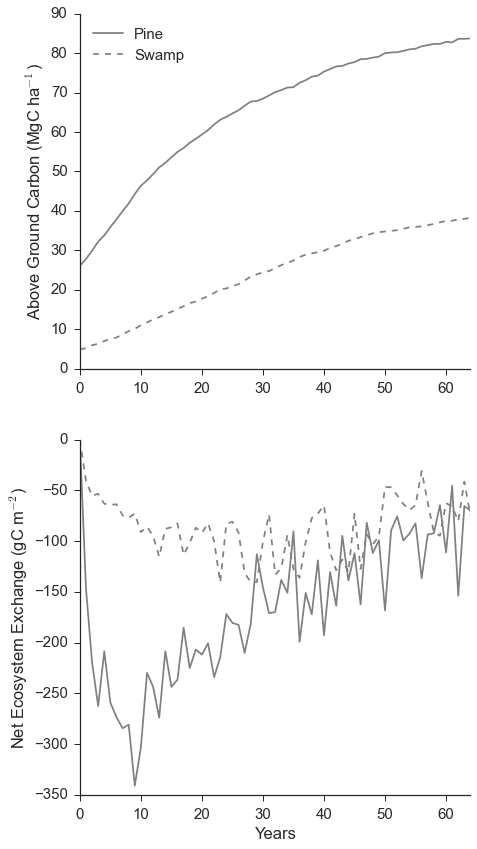

In [21]:
outputDir = 'C:/Research/Osceola/InitialRuns/'
centFile = 'NECN-succession-log.csv'
sppBiofile = 'spp-biomass-log.csv'
NECNDF = pd.read_csv(outputDir + centFile)
NECNDF['AGC'] = NECNDF.AGB * 0.01 * 0.5
Pine = NECNDF[NECNDF.EcoregionIndex == 1]
Swamp = NECNDF[NECNDF.EcoregionIndex == 2]

f, (ax1, ax2) = plt.subplots(2,1, figsize = (7,14))
Pine.plot(x = 'Time', y = 'AGC', ax = ax1, color = 'gray')
Swamp.plot(x = 'Time', y = 'AGC', ax = ax1, color = 'gray', linestyle = '--')

Pine.plot(x = 'Time', y = 'NEEC', ax = ax2, color = 'gray')
Swamp.plot(x = 'Time', y = 'NEEC', ax = ax2, color = 'gray', linestyle = '--')


ax1.legend(['Pine', 'Swamp'], loc = 0)
ax2.legend([])
ax1.set_ylabel('Above Ground Carbon (MgC ha$^{-1}$)')
ax2.set_ylabel('Net Ecosystem Exchange (gC m$^{-2}$)')

ax1.set_xlabel('')
ax2.set_xlabel('Years')


sns.despine()

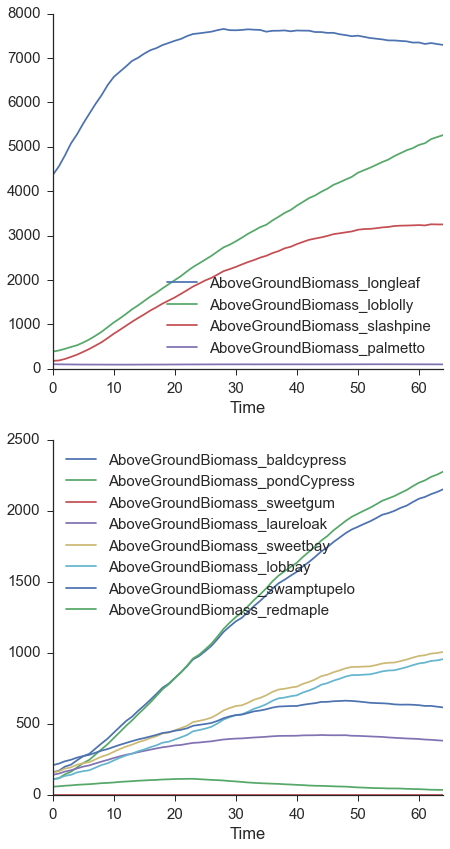

In [22]:
sppBio = pd.read_csv(outputDir + sppBiofile)
osceolaPSpecies = ['longleaf', 'loblolly', 'slashpine','palmetto']

osceolaSSpecies = ['baldcypress', 'pondCypress', 'sweetgum', 
                  'laureloak', 'sweetbay', 'lobbay', 
                  'swamptupelo', 'redmaple']



f, (ax1, ax2) = plt.subplots(2,1, figsize = (7,14))
pineSpp = sppBio[sppBio.EcoName == ' ECO1']
swampSpp = sppBio[sppBio.EcoName == ' ECO2']

pineSpp = pineSpp.apply(pd.to_numeric, errors='ignore')
swampSpp = swampSpp.apply(pd.to_numeric, errors='ignore')

for species in osceolaPSpecies:
    pineSpp.plot(x = 'Time', y = 'AboveGroundBiomass_' + species, ax = ax1)
for species in osceolaSSpecies:
    swampSpp.plot(x = 'Time', y = 'AboveGroundBiomass_' + species, ax = ax2)

sns.despine()

### Simulation wide patterns and trends look good
May lower initial ecoregion mineral nitrogen

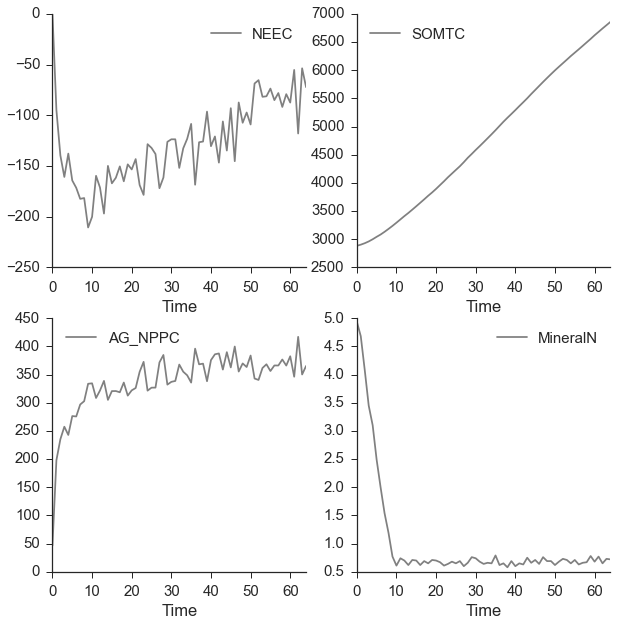

In [23]:
NECN_Summary = pd.read_csv(outputDir + 'NECN-succession-log-short.csv')
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (10,10))

NECN_Summary.plot(x = 'Time', y = 'NEEC', ax = ax1, color = 'gray')
NECN_Summary.plot(x = 'Time', y = 'SOMTC', ax = ax2, color = 'gray')
NECN_Summary.plot(x = 'Time', y = 'AG_NPPC', ax = ax3, color = 'gray')
NECN_Summary.plot(x = 'Time', y = 'MineralN', ax = ax4, color = 'gray')


sns.despine()

### Using projected climate for the landscape
is easy, but generating fire weather from it to drive the DFFS takes more time. Here I grabbed the MACA_CNRM historic data, because it also comes with wind speed in two vectors, and rH.  

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=120,center=False).mean()


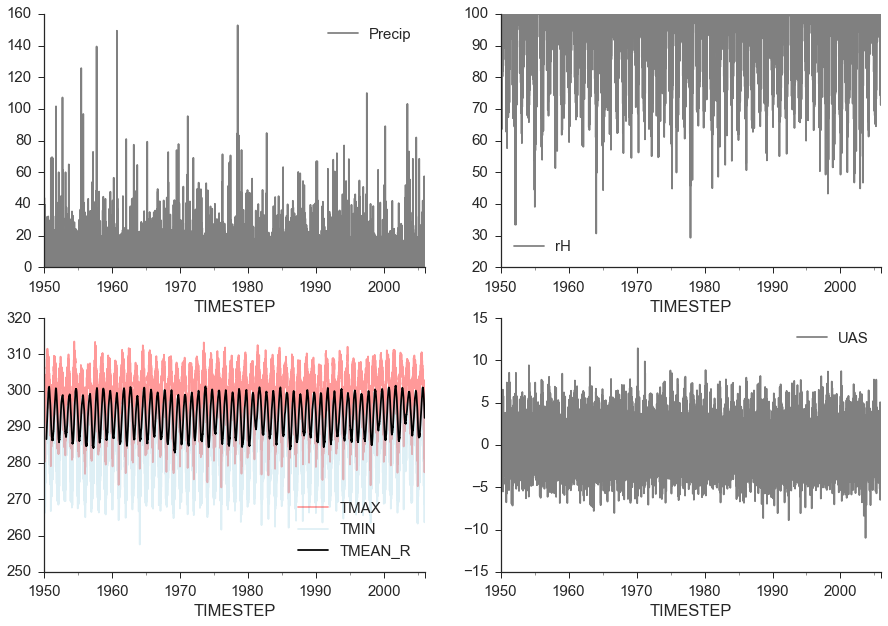

In [24]:
fireWeatherFile = outputDir + 'osceola_MACA_CNRM_frmt.csv'
fireW = pd.read_csv(fireWeatherFile)

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (15,10))
fireW.index = pd.to_datetime(fireW.TIMESTEP)

fireW['TMEAN'] = (fireW.TMAX + fireW.TMIN) / 2
fireW['TMEAN_R']  = pd.rolling_mean(fireW.TMEAN, 120)

fireW.plot(x = fireW.index, y = 'Precip', ax = ax1, color = 'gray')
fireW.plot(x = fireW.index, y = 'rH', ax = ax2, color = 'gray')
fireW.plot(x = fireW.index, y = 'TMAX', ax = ax3, color = 'red', alpha = 0.4)
fireW.plot(x = fireW.index, y = 'TMIN', ax = ax3, color = 'lightblue', alpha = 0.4)

fireW.plot(x = fireW.index, y = 'TMEAN_R', ax = ax3, color = 'black')


fireW.plot(x = fireW.index, y = 'UAS', ax = ax4, color = 'gray')

sns.despine()
sns.set_style('ticks')

### The windspeed data
is a velocity of either north or east, and can be negative. I need to feed LANDIS 365 degree wind data with only positive values

In [25]:
fireW
v = fireW['VAS']/fireW['windspeed']
u = fireW['UAS']/fireW['windspeed']
dirRad = np.arctan2(v, u) 
dirDeg = dirRad * 180/math.pi
metDir = dirDeg + 180
fireW['WDIR'] = metDir

KeyError: 'windspeed'

### Now we have to format the data to look like RAWS data 
so we can plug it into the existing RAWS to LANDIS fire weather generation scripts.

In [26]:
osceolaRaws = pd.DataFrame()
osceolaRaws['year'] = fireW.index.year
osceolaRaws['juliandate'] = fireW.index.dayofyear
osceolaRaws['temp'] = ((fireW.TMAX + fireW.TMIN) / 2).ravel() - 273.15
osceolaRaws['windspeed'] = fireW['windspeed'].ravel() * 3.6
osceolaRaws['windazimuth'] = fireW['WDIR'].astype(int).ravel()
osceolaRaws['relativehumidity'] = fireW['rH'].astype(int).ravel()
osceolaRaws['precip_mm'] = np.round(fireW.Precip.ravel(), 2)
osceolaRaws.to_csv('C:/Research/Osceola/InitialRuns/osceolaRAWS_DATA.csv', index = False)
osceolaRaws.head()

KeyError: 'windspeed'

### And finally convert the weather observations to Landis FW

In [ ]:
from FireWeatherIndex_Calculations import DynamicFireWeatherCalculations

for region in ['FR1','FR2']:
    p = DynamicFireWeatherCalculations(outputDir + 'osceolaRAWS_DATA.csv',
                                           outputDir + 'sample_startingvalues_' + region + '.csv',
                                           outputDir +  region + '_FireWeather.csv', region)
    p.run()

### The spin-up conteporary FW doesnt generate many high sev events
as it stands currently. One way to address this is to see if the fire weather will become more severe with time over the course of the simulation. We need to drive extreme heat fires with high winds and low RH. So, we're going to take Daymet observations and drive the climate with random years, and use RAWS data to drive the fire weather. First we need to cut up the fire weather.

In [17]:
def adjustWindAz(windDir):
    if math.degrees(math.radians(windDir) + math.radians(180)) > 360:
        windDir_adj = math.degrees(math.radians(windDir) + math.radians(180)) - 360
    else:
        windDir_adj = math.degrees(math.radians(windDir) + math.radians(180))
    return windDir_adj
        
# Function to clean up the mask values and data types from the RAWS outputs. Note, here the RAWS ASCII Downloads
# have to be manually edited to conform to the sample input from Louise's script in order to run.

def cleanRaws(formattedRawsData, maskValue, yearStart, yearStop, cleanedRawsData, windFix):
    rawsdata = pd.read_csv(formattedRawsData)
    rawsdata[rawsdata == maskValue] = np.nan
    rawsdata = rawsdata.dropna()
    rawsdata.Juliandate = rawsdata.Juliandate.astype(int)
    if windFix == 'yes':
        print 'Converting wind directions.....'
        rawsdata.windazimuth = rawsdata.windazimuth.apply(adjustWindAz) # wind direction adjustment
    rawsdata.windazimuth = rawsdata.windazimuth.astype(int)
    rawsdata.relativehumidity = rawsdata.relativehumidity.astype(int)
    rawsdata = rawsdata[rawsdata.year > yearStart]
    rawsdata = rawsdata[rawsdata.year < yearStop]
    if windFix == 'yes':
        rawsdata.windspeed = rawsdata.windspeed * 3.6 # Convert m/s to km/h

    rawsdata.to_csv(cleanedRawsData, index = False)
    

### Now we can take a look at the data
and characterize what portion may constitute 'extreme' fire weather. One way to do this is to chunk it up by quantiles, and take the upper 10th percentile.

Converting wind directions.....


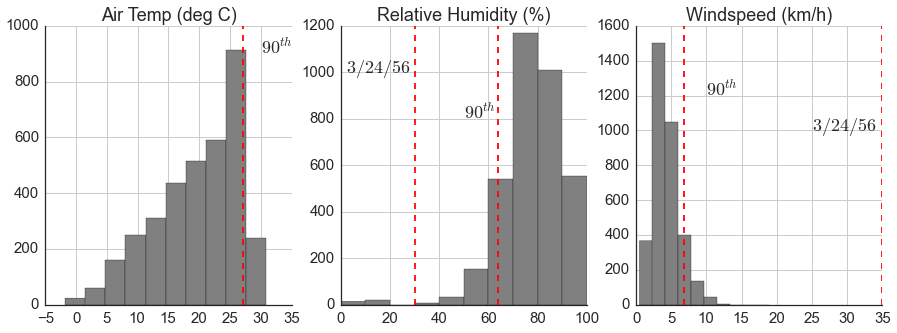

In [18]:
cleanRaws('C:/Research/Osceola/osceolaRawsContemporary.csv', -9999, 2005, 2016, 'cleanedOsceolaRawsContemporary.csv', 'yes')  
osceolaraws = pd.read_csv('C:/Research/Osceola/cleanedOsceolaRawsContemporary.csv')
osceolaraws[osceolaraws.windspeed > 70] = 10
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
osceolaraws.temp.hist(ax = ax1, color = 'gray')
osceolaraws.relativehumidity.hist(ax = ax2, color = 'gray')
osceolaraws.windspeed.hist(ax = ax3, color = 'gray')

ax1.set_title('Air Temp (deg C)')
ax2.set_title('Relative Humidity (%)')
ax3.set_title('Windspeed (km/h)')

ax1.vlines(osceolaraws.temp.quantile(.90), 0, 1000, linestyle = '--', color = 'red')
ax2.vlines([osceolaraws.relativehumidity.quantile(.10), 30], 0, 1200, linestyle = '--', color = 'red')
ax1.text(30, 900, r'$90^{th}$')
ax2.text(50, 800, r'$90^{th}$')
ax2.text(2, 1000, r'$3/24/56$')
ax3.text(10, 1200, r'$90^{th}$')
ax3.text(25, 1000, r'$3/24/56$')

ax3.vlines([osceolaraws.windspeed.quantile(.90), 35], 0, 1600, linestyle = '--', color = 'red')

sns.despine()
sns.set_style('ticks')

### Seems like we're capturing temp and rH but not so much windspeed
The differences between the 90th percentile and the historic target are too large. One option is to add in the 'wind gust' data from the RAWS record. lets visualize that on top of the avg. wind speed and see how it looks.

Converting wind directions.....
Converting wind directions.....


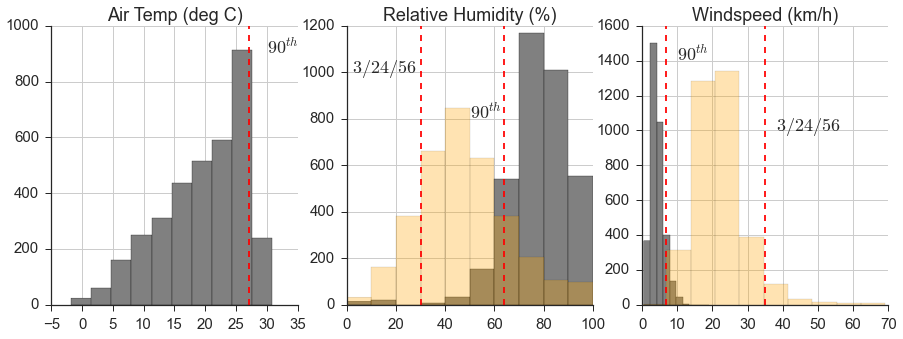

In [19]:
cleanRaws('C:/Research/Osceola/osceolaRawsContemporary.csv', -9999, 2005, 2016, 'cleanedOsceolaRawsContemporary.csv', 'yes')  
osceolaraws = pd.read_csv('C:/Research/Osceola/cleanedOsceolaRawsContemporary.csv')

cleanRaws('C:/Research/Osceola/osceolaRawsExtreme.csv', -9999, 2005, 2016, 'cleanedOsceolaRawsExtreme.csv', 'yes')  
osceolarawsExtreme = pd.read_csv('C:/Research/Osceola/cleanedOsceolaRawsExtreme.csv')

osceolaraws[osceolaraws.windspeed > 70] = 10
osceolarawsExtreme[osceolarawsExtreme.windspeed > 70] = 10

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
osceolaraws.temp.hist(ax = ax1, color = 'gray')
osceolaraws.relativehumidity.hist(ax = ax2, color = 'gray')
osceolarawsExtreme.relativehumidity.hist(ax = ax2, color = 'orange', alpha = 0.3)

osceolaraws.windspeed.hist(ax = ax3, color = 'gray')
osceolarawsExtreme.windspeed.hist(ax = ax3, color = 'orange', alpha = 0.3)

ax1.set_title('Air Temp (deg C)')
ax2.set_title('Relative Humidity (%)')
ax3.set_title('Windspeed (km/h)')

ax1.vlines(osceolaraws.temp.quantile(.90), 0, 1000, linestyle = '--', color = 'red')
ax2.vlines([osceolaraws.relativehumidity.quantile(.10), 30], 0, 1200, linestyle = '--', color = 'red')
ax1.text(30, 900, r'$90^{th}$')
ax2.text(50, 800, r'$90^{th}$')
ax2.text(2, 1000, r'$3/24/56$')
ax3.text(10, 1400, r'$90^{th}$')
ax3.text(38, 1000, r'$3/24/56$')

ax3.vlines([osceolaraws.windspeed.quantile(.90), 35], 0, 1600, linestyle = '--', color = 'red')

sns.despine()
sns.set_style('ticks')
plt.savefig('ContemporaryExtremeFW.tif', dpi = 300)

### Looks like by replacing rH and WSV with the high values from RAWS
we can generate data that match up pretty well with the observed FW that resulted in extreme events historically. This is identical to the approach we took for the first Dink manuscript. Nowe we just have to make a finalized 'extreme' RAWS file and generate the fire weather from that using our modified script from Louise.

In [ ]:
for region in ['FR1','FR2']:
    p = DynamicFireWeatherCalculations(outputDir + 'cleanedOsceolaRawsExtreme.csv',
                                           outputDir + 'sample_startingvalues_' + region + '.csv',
                                           outputDir +  region + '_FireWeatherE.csv', region)
    
    p = DynamicFireWeatherCalculations(outputDir + 'cleanedOsceolaRawsContemporary.csv',
                                           outputDir + 'sample_startingvalues_' + region + '.csv',
                                           outputDir +  region + '_FireWeather.csv', region)

    p.run()

### Things are looking good fire and C wise
but the runs are taking forever. We need to downsample the grid cells for each Osceola raster to 150m. Thats going to result in 2.25 ha grid cells, which should significantly reduce the number of cohorts and subsequently the run time.

In [ ]:
ECOraster = importRaster('C:/Research/Osceola/SpatialData/' + 'osceolaeco1501.tif')
ICraster = importRaster('C:/Research/Osceola/SpatialData/' + 'thisIC_150.tif')
ICraster[ICraster > 0] = 1
strictEco = (ICraster * ECOraster)
saveAsGeoTiff('C:/Research/Osceola/SpatialData/' + 'thisIC_150.tif', 
              strictEco, 'C:/Research/Osceola/SpatialData/' + 'Osceola_Ecoregions_150.tif', 26917)